In [1]:
from io import BytesIO
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [2]:
def arr2img(arr):
    """Display a 2- or 3-d numpy array as an image."""
    if arr.ndim == 2:
        format, cmap = 'png', mpl.cm.gray
    elif arr.ndim == 3:
        format, cmap = 'jpg', None
    else:
        raise ValueError("Only 2- or 3-d arrays can be displayed as images.")
    # Don't let matplotlib autoscale the color range so we can control overall luminosity
    #vmax = 255 if arr.dtype == 'uint8' else 1.0
    vmax=1.0
    with BytesIO() as buffer:
        mpl.image.imsave(buffer, arr, format=format, cmap=cmap, vmin=0, vmax=vmax)
        out = buffer.getvalue()
    return Image(out)

In [3]:
%matplotlib inline    


In [4]:
%pwd

'/home/nick/dev/trc-follow-me/notebooks'

In [5]:
def load_test_images(glob_regex='../samples/*.jpg'):
    images=[]
    for f in glob.glob(glob_regex):
        img=cv2.imread(f)
        img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        images.append((f,img))
        
    return images

def load_test_video(file_name='../samples/WIN_20180209_01_33_19_Pro.mp4'):
    images=[]
    count=0
    
    def convert_frame(img):
        nonlocal count
        #img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        f="%s - %d" % (file_name, count)
        count += 1
        return (f,img)
    
    clip = VideoFileClip(file_name)
    images = [convert_frame(frame) for frame in clip.iter_frames(progress_bar=True)]
    
    return images

../samples/5m-slight right.jpg


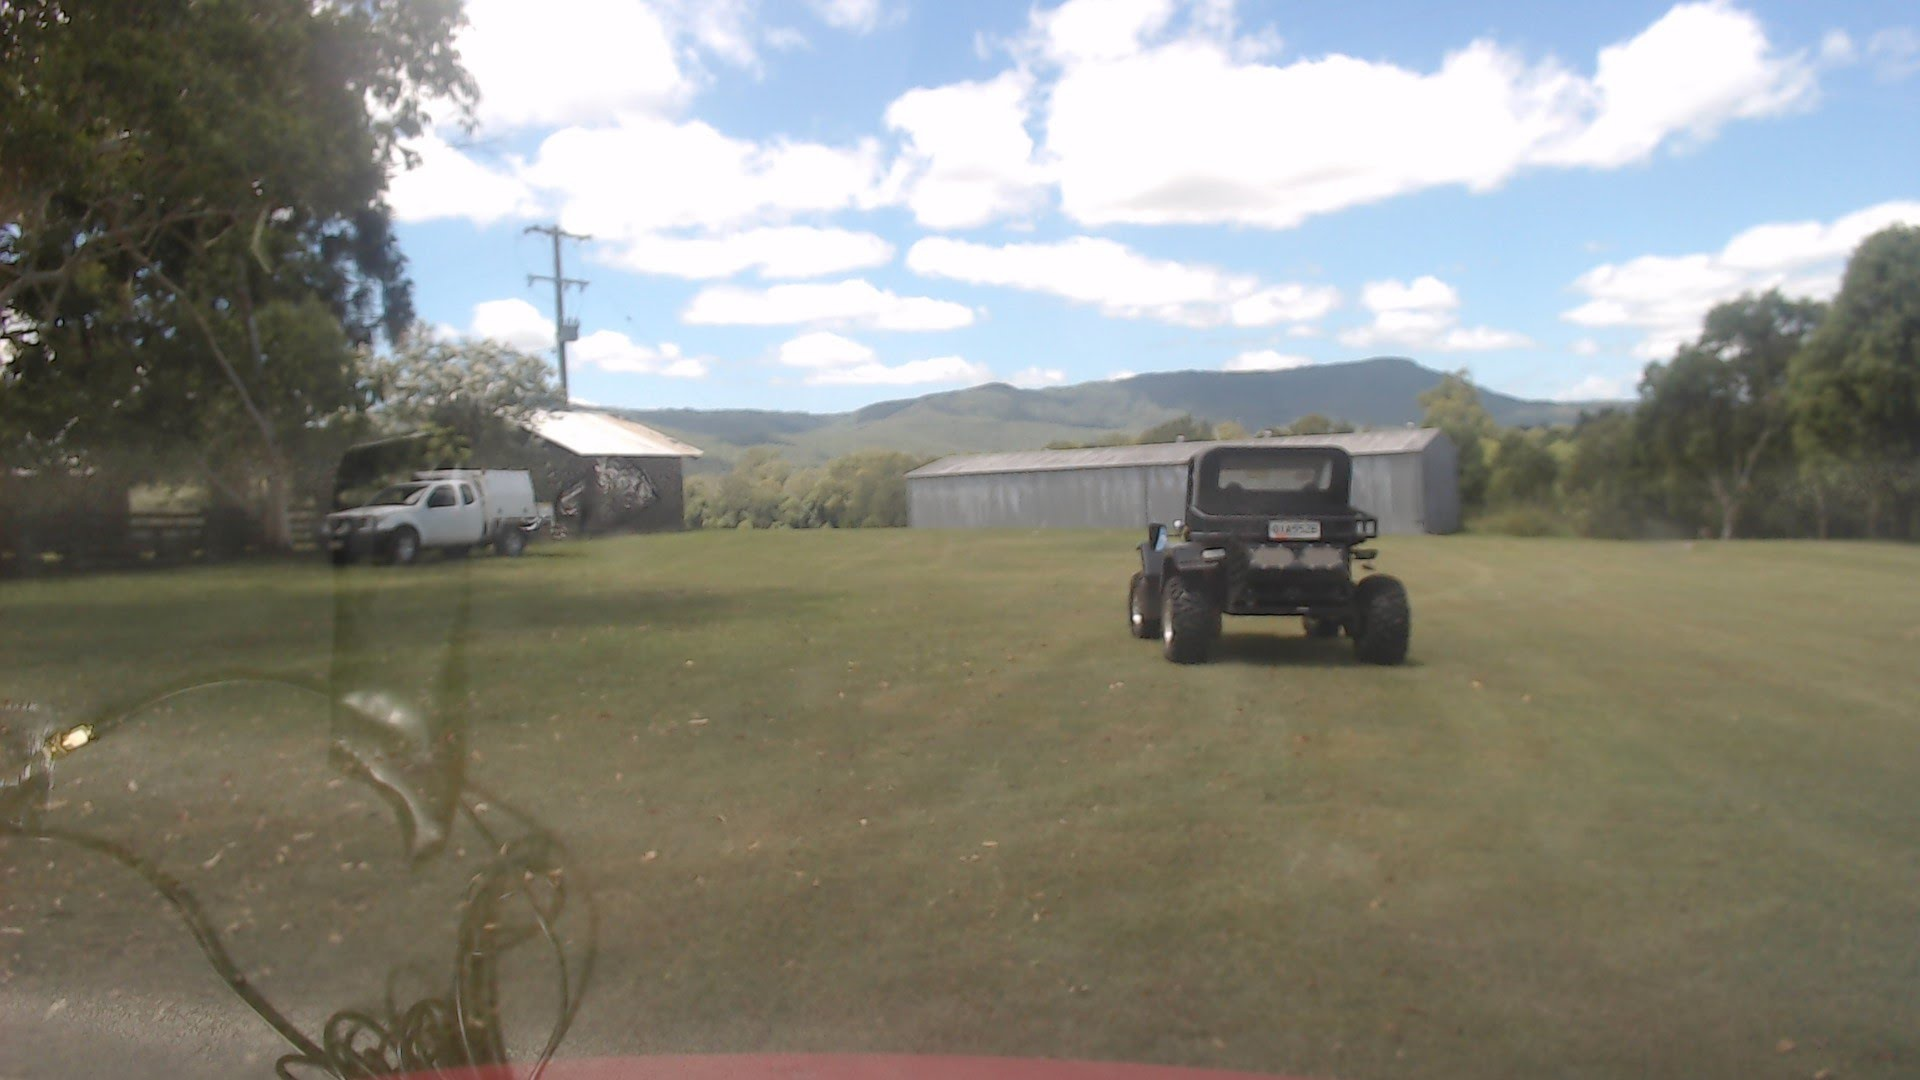

In [6]:
images = load_test_images()
file,img=images[0]
print(file)
arr2img(img)

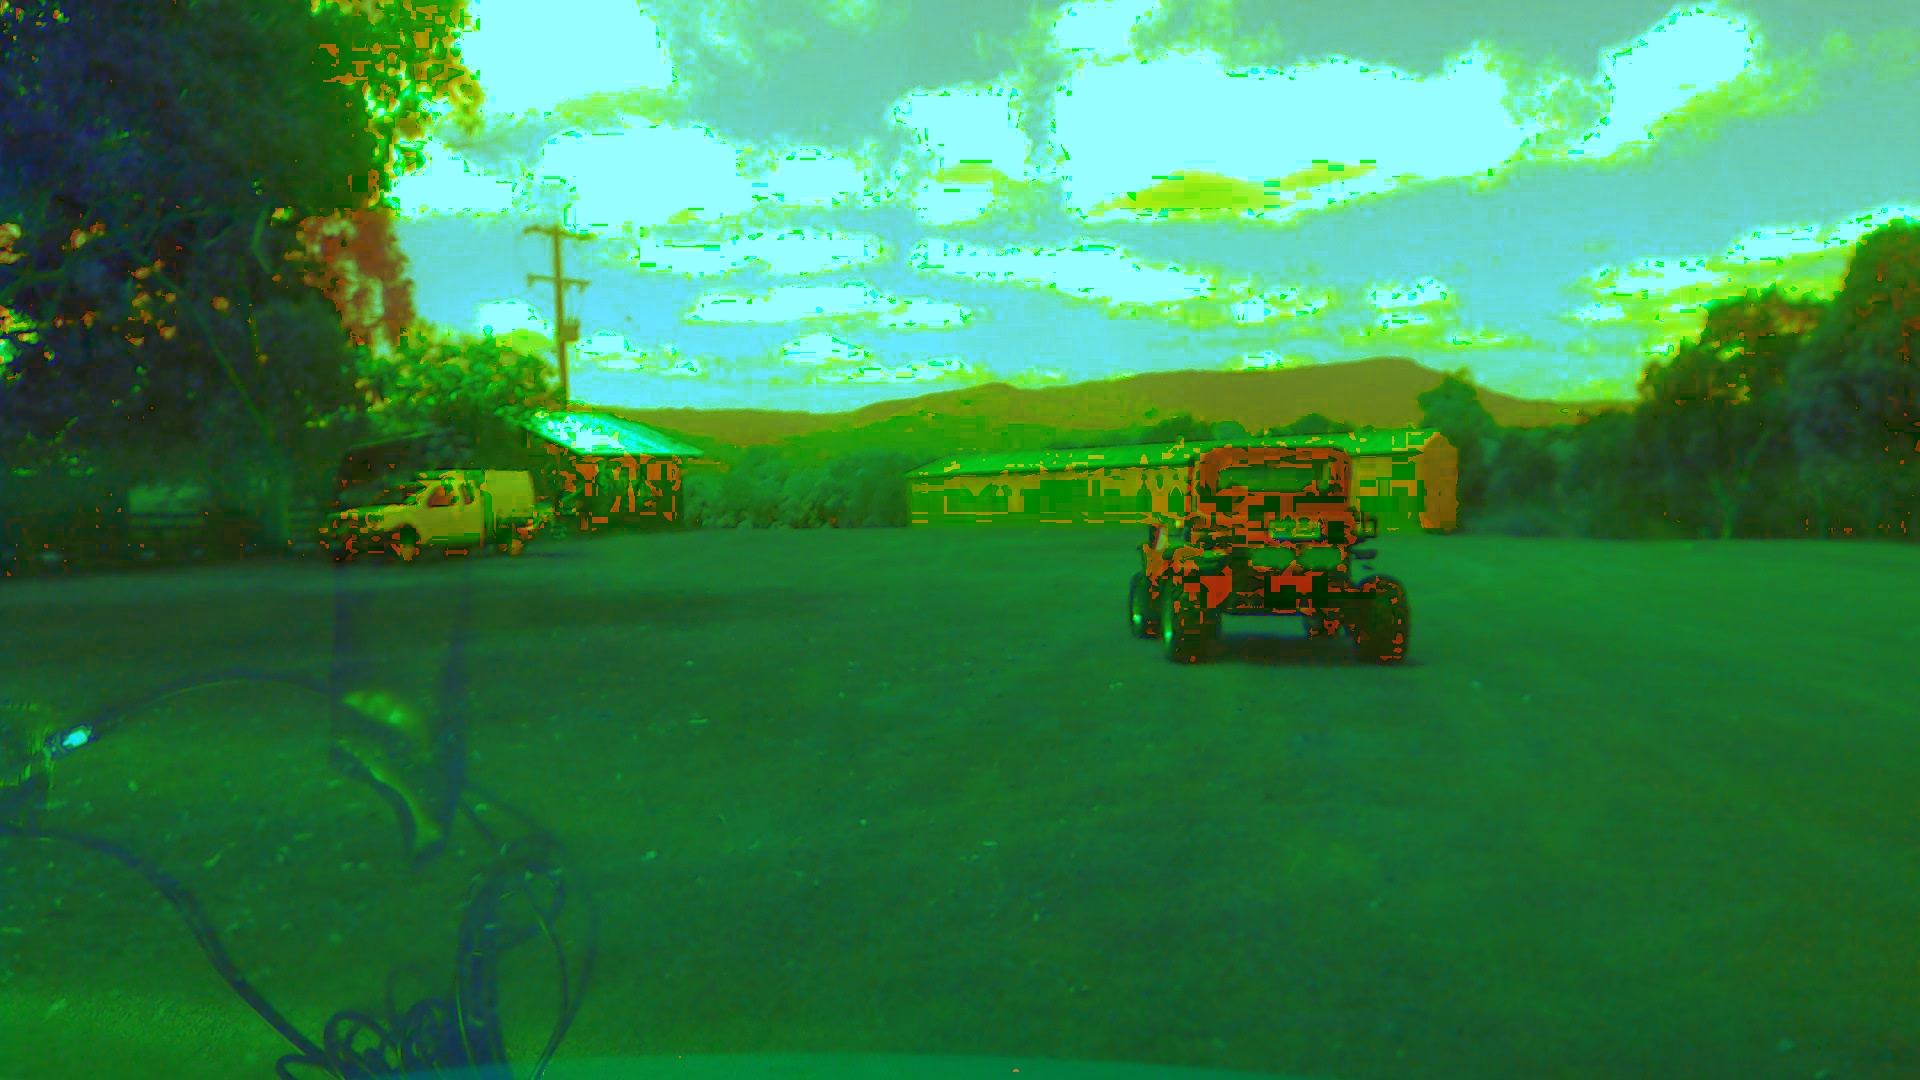

In [7]:
def binary_thresh(channel, thresh = (0, 255), on = 1):
    binary = np.zeros_like(channel)
    binary[(channel > thresh[0]) & (channel <= thresh[1])] = on

    return binary

# HLS colour
hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
H = hls[:,:,0]
L = hls[:,:,1]
S = hls[:,:,2]
# arr2img(binary_thresh(L, thresh = (0,125)))
arr2img(hls)

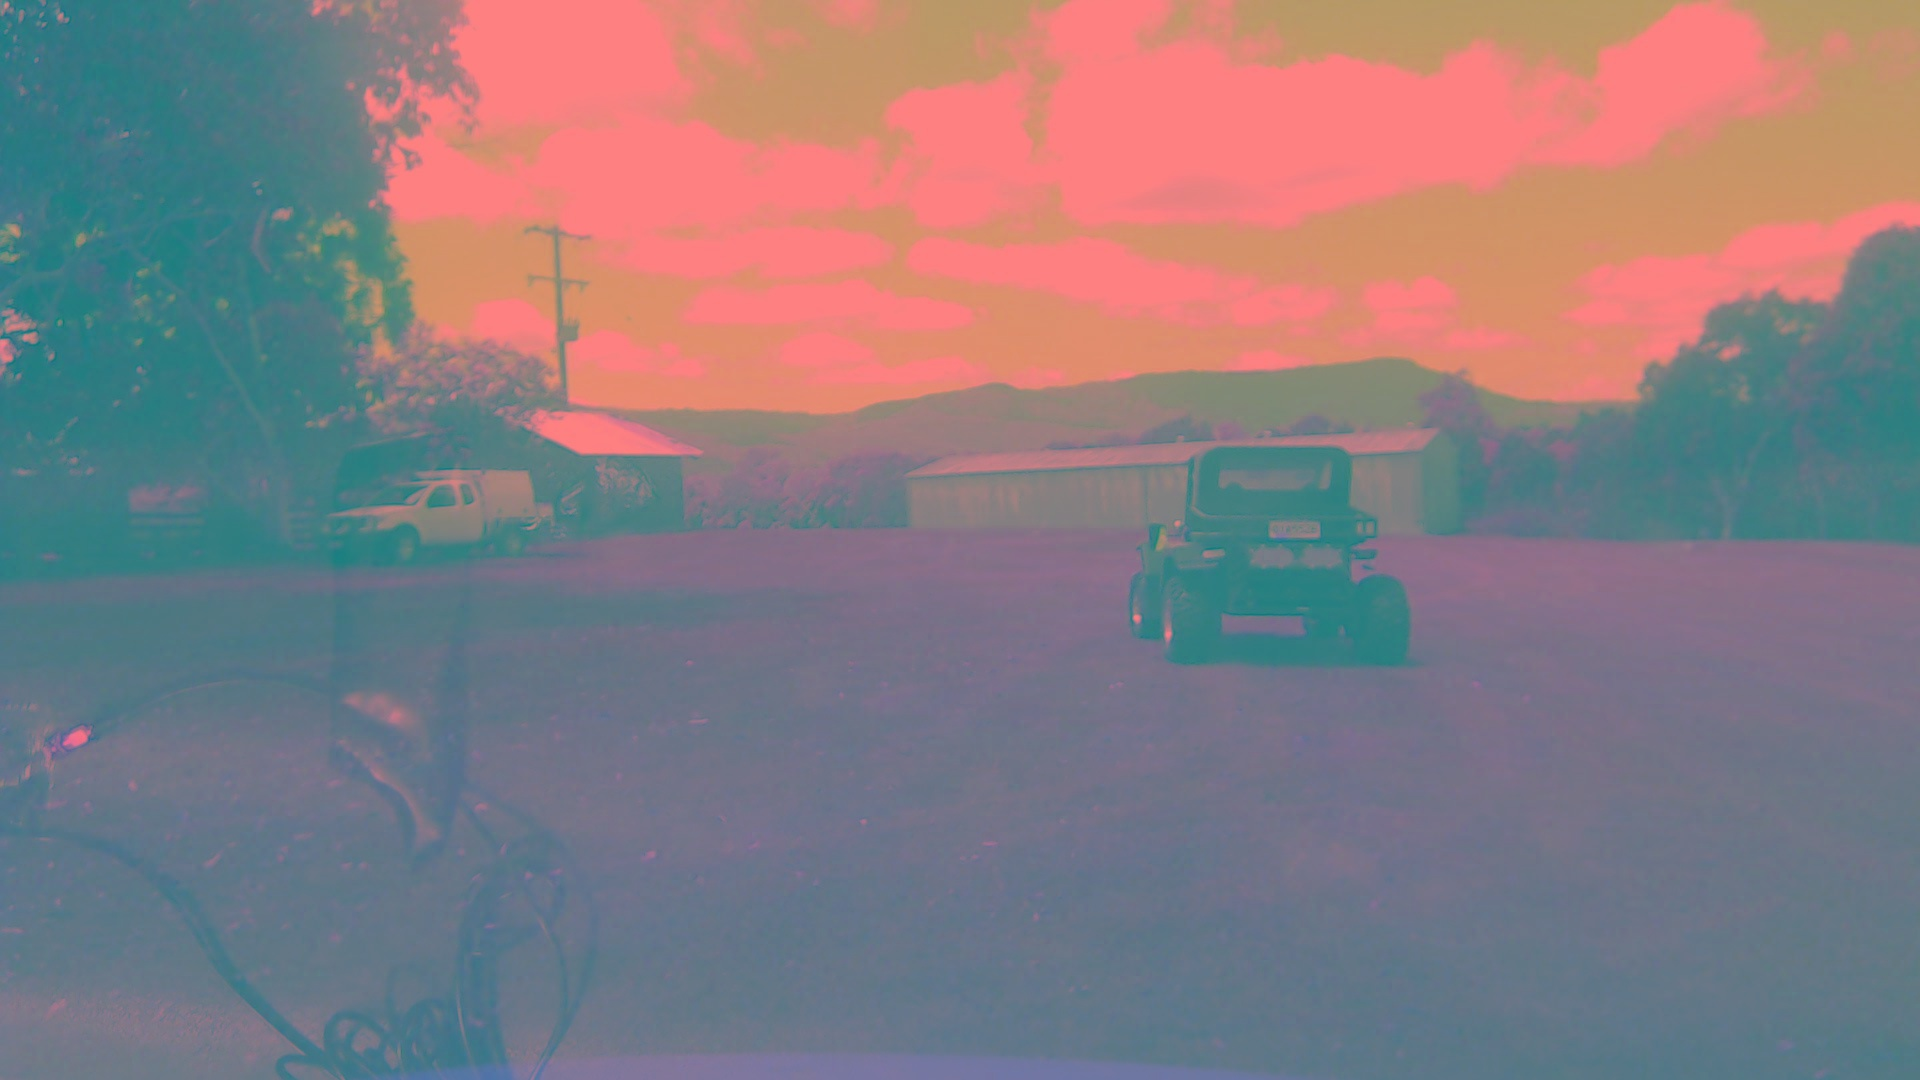

In [8]:
# YUV colour
yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
Y = yuv[:,:,0]
U = yuv[:,:,1]
V = yuv[:,:,2]
# arr2img(binary_thresh(U, thresh = (125,255)))
arr2img(yuv)

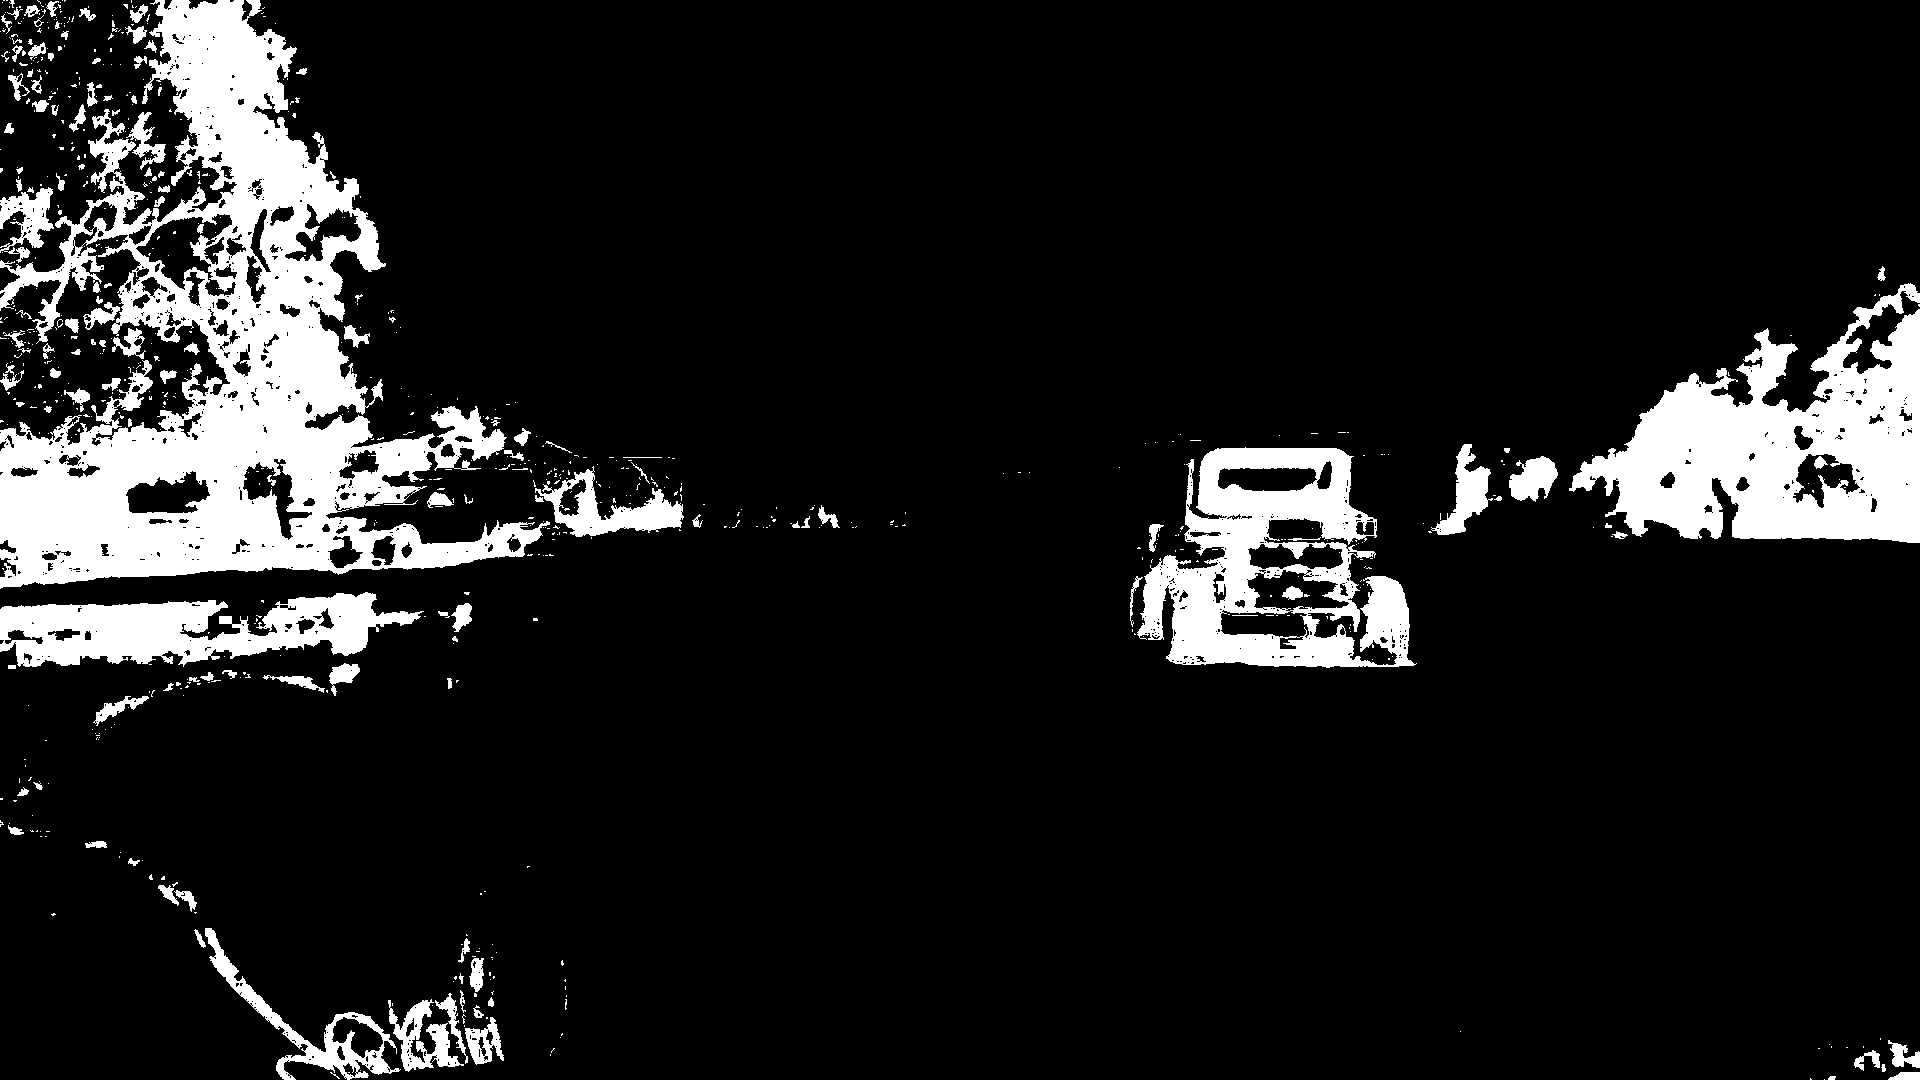

In [9]:
# RGB colour
R = img[:,:,2]
G = img[:,:,1]
B = img[:,:,0]
rbinary = binary_thresh(R, (40,85))
gbinary = binary_thresh(G, (43,85))
bbinary = binary_thresh(B, (40,85))
arr2img(rbinary & gbinary & bbinary)


In [10]:
def draw_lines(img, vertices):
    pts= np.int32([vertices])
    cv2.polylines(img, pts, True, (0,0,255))

def perspective_transforms(src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return M, Minv

def perspective_warp(img, M):
#     img_size = (img.shape[1], img.shape[0])
    img_size = (img.shape[0], img.shape[1])
    
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped

def perspective_unwarp(img, Minv):
#     img_size = (img.shape[1], img.shape[0])
    img_size = (img.shape[0], img.shape[1])
    
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return unwarped
    
def calc_warp_points(img_height,img_width,x_center_adj=0):
    
    # calculator the vertices of the region of interest
    imshape = (img_height, img_width)
    xcenter=imshape[1]/2+x_center_adj
#     xfd=55
#     yf=450
#     xoffset=100
    xfd=600
    yf=540
    xoffset=25
    
    src = np.float32(
        [(xoffset,imshape[0]),
         (xcenter-xfd, yf), 
         (xcenter+xfd,yf), 
         (imshape[1]-xoffset,imshape[0])])
    
    # calculator the destination points of the warp
#     dst = np.float32(
#         [(xoffset,imshape[0]),
#          (xoffset,0),
#          (imshape[1]-xoffset, 0),
#         (imshape[1]-xoffset,imshape[0])])
    
    dst = np.float32(
        [(xoffset,imshape[1]),
         (xoffset,0),
         (imshape[0]-xoffset, 0),
        (imshape[0]-xoffset,imshape[1])])
        
    return src, dst
    
def binary_topdown(img, threshold="daytime-normal"):
    # camera undistort
    undistorted=undistort_image(img)
    
    # top down view warp of the undistorted binary image
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])

    # calculate matrix for perspective warp
    M, _ = perspective_transforms(src, dst)
    
    
    def noise_detect(warped):
        histogram=np.sum(warped, axis = 1)
        return (histogram > 100).any()
        
    # use the default
    if threshold == "daytime-normal":
        # this works in normal daytime conditions
        combined=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(combined, M)
        if noise_detect(warped):
            combined=combined_threshold(undistorted, threshold="daytime-shadow")
            warped = perspective_warp(combined, M)
    else:
        undistorted=combined_threshold(undistorted, threshold=threshold)
        warped = perspective_warp(undistorted, M)
    
    return warped

In [11]:
def combined_threshold(img, kernel=3, grad_thresh=(27,70), mag_thresh=(70,100), dir_thresh=(0.8, 0.9),
                       s_thresh=(100,255), r_thresh=(40,85), g_thresh=(43,85), b_thresh=(40,85), u_thresh=(140,180),
                      threshold="daytime-normal"):

    def binary_thresh(channel, thresh = (200, 255), on = 1):
        binary = np.zeros_like(channel)
        binary[(channel > thresh[0]) & (channel <= thresh[1])] = on

        return binary
    
    # overwrite defaults
#     if threshold == "daytime-shadow":
#         grad_thresh=(15,100)

    # check up the default red_min threshold to cut out noise and detect white lines
    if threshold in ["daytime-bright","daytime-filter-pavement"]:
         r_thresh=(210,255)
        
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=kernel)
    
    # calculate the scobel x gradient binary
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    gradx = binary_thresh(scaled_sobelx, grad_thresh)
    
    # calculate the scobel y gradient binary
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    grady = binary_thresh(scaled_sobely, grad_thresh)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    mag_binary = binary_thresh(gradmag, mag_thresh)
    
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary = binary_thresh(absgraddir, dir_thresh)
    
    # HLS colour
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    sbinary = binary_thresh(S, s_thresh)
    
    # RGB colour
    R = img[:,:,2]
    G = img[:,:,1]
    B = img[:,:,0]
    rbinary = binary_thresh(R, r_thresh)
    gbinary = binary_thresh(G, g_thresh)
    bbinary = binary_thresh(B, b_thresh)
    
    # YUV colour
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    Y = yuv[:,:,0]
    U = yuv[:,:,1]
    V = yuv[:,:,2]
    ubinary = binary_thresh(U, u_thresh)
    
    combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
#     combined[(gradx == 1) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1) | (ubinary ==1) | (rbinary == 1) ] = 1
    
    
    # combined[((gradx == 1) | (rbinary == 1)) & ( (sbinary ==1) | (ubinary ==1)| (rbinary == 1 ))] = 1
    
#     combined[((gradx == 1) | (rbinary == 1)) ] = 1
    #combined[(gradx == 1) | (ubinary == 1) | (rbinary == 1) ] = 1
    
    if threshold == "daytime-normal": # default
        combined[(rbinary == 1) & (gbinary == 1) & (bbinary == 1) ] = 1
    elif threshold == "daytime-shadow":
        combined[((gradx == 1) & (grady == 1)) | (rbinary == 1)] = 1
    elif threshold == "daytime-bright":
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (sbinary ==1 ) | (rbinary == 1)] = 1
    else:
        combined[((gradx == 1) | (rbinary == 1)) & ( (sbinary ==1) | (ubinary ==1)| (rbinary == 1 ))] = 1
        
    return combined

In [12]:
images = load_test_images()
@interact(images=fixed(images),i=widgets.IntSlider(min=0,max=len(images)-1,step=1),
          sobel_kernel=widgets.IntSlider(min=3,max=21,step=2,value=3),
          grad_min=widgets.IntSlider(min=0,max=255,step=1,value=27),
          grad_max=widgets.IntSlider(min=0,max=255,step=1,value=70),
          mag_min=widgets.IntSlider(min=0,max=255,step=1,value=70),
          mag_max=widgets.IntSlider(min=0,max=255,step=1,value=100),
          dir_min=widgets.FloatSlider(min=0.,max=np.pi/2,step=.1,value=0.8),
          dir_max=widgets.FloatSlider(min=0.,max=np.pi/2,step=.1,value=0.9),
          s_min=widgets.IntSlider(min=0,max=255,step=1,value=100),
          s_max=widgets.IntSlider(min=0,max=255,step=1,value=255),
          r_min=widgets.IntSlider(min=0,max=255,step=1,value=40),
          r_max=widgets.IntSlider(min=0,max=255,step=1,value=85),
          g_min=widgets.IntSlider(min=0,max=255,step=1,value=43),
          g_max=widgets.IntSlider(min=0,max=255,step=1,value=85),
          b_min=widgets.IntSlider(min=0,max=255,step=1,value=40),
          b_max=widgets.IntSlider(min=0,max=255,step=1,value=85),
          u_min=widgets.IntSlider(min=0,max=255,step=1,value=140),
          u_max=widgets.IntSlider(min=0,max=255,step=1,value=180),
          threshold=["daytime-normal","daytime-shadow","daytime-bright","daytime-filter-pavement","other"])                    
def combined_threshold_image(images=fixed(images), i=0, 
                    sobel_kernel=3,
                    grad_min =27, grad_max=70,
                    mag_min=70, mag_max=100,
                    dir_min=0.8, dir_max=0.9,
                  
                    s_min=100, s_max=255,
                    r_min=240, r_max=255,
                    g_min=60, g_max=255,
                    b_min=40, b_max=60,
                    u_min=140, u_max=180,
                    threshold="daytime-normal"):
  
    file,img=images[i]
    dir_binary=combined_threshold(img, sobel_kernel,
                                  grad_thresh=(grad_min, grad_max),
                                  mag_thresh=(mag_min, mag_max),
                                  dir_thresh=(dir_min, dir_max),
                                  s_thresh=(s_min, s_max),
                                  r_thresh=(r_min, r_max),
                                  g_thresh=(g_min, g_max),
                                  b_thresh=(b_min, b_max),
                                  u_thresh=(u_min, u_max),
                                  threshold=threshold
                                 )
    return arr2img(dir_binary)

interactive(children=(IntSlider(value=0, description='i', max=2), IntSlider(value=3, description='sobel_kernel', max=21, min=3, step=2), IntSlider(value=27, description='grad_min', max=255), IntSlider(value=70, description='grad_max', max=255), IntSlider(value=70, description='mag_min', max=255), IntSlider(value=100, description='mag_max', max=255), FloatSlider(value=0.8, description='dir_min', max=1.5707963267948966), FloatSlider(value=0.9, description='dir_max', max=1.5707963267948966), IntSlider(value=100, description='s_min', max=255), IntSlider(value=255, description='s_max', max=255), IntSlider(value=40, description='r_min', max=255), IntSlider(value=85, description='r_max', max=255), IntSlider(value=43, description='g_min', max=255), IntSlider(value=85, description='g_max', max=255), IntSlider(value=40, description='b_min', max=255), IntSlider(value=85, description='b_max', max=255), IntSlider(value=140, description='u_min', max=255), IntSlider(value=180, description='u_max', max=255), Dropdown(description='threshold', options=('daytime-normal', 'daytime-shadow', 'daytime-bright', 'daytime-filter-pavement', 'other'), value='daytime-normal'), Output()), _dom_classes=('widget-interact',))

In [13]:
#images = load_test_images()
images = load_test_video()
# images = load_test_video(file_name='project_video_shadow.mp4')

@interact(images=fixed(images),i=widgets.IntSlider(min=0,max=len(images)-1,step=1), threshold_flag=False)
def transform_test(images, i, threshold_flag):
    file,img=images[i]
#     undistorted=undistort_image(img)
    undistorted=img
    if threshold_flag:
        undistorted=combined_threshold(undistorted)
    #vertices=[(700,200), (700,1100), (400,700), (400,500)]
    
    src, dst = calc_warp_points(undistorted.shape[0],undistorted.shape[1])
    M, _ = perspective_transforms(src, dst)
    draw_lines(undistorted,src)
    
    warped = perspective_warp(undistorted, M)

    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(undistorted, cmap="gray")
    ax1.set_title(file, fontsize=30)
    ax2.imshow(warped, cmap="gray")
    ax2.set_title('Undistorted & Warped Image', fontsize=30)

100%|██████████| 3453/3453 [00:25<00:00, 136.01it/s]


interactive(children=(IntSlider(value=0, description='i', max=3452), Checkbox(value=False, description='threshold_flag'), Output()), _dom_classes=('widget-interact',))